# Importing Libraries

In [1]:
# File Handling and Path Operations
import os
from glob import glob

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
#splitter
from sklearn.model_selection import train_test_split
#preprocessor
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# TensorFlow/Keras for Deep Learning

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Scikit-learn for Evaluation Metrics
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 2


# Data Collection

In [3]:
import kagglehub
kmader_skin_cancer_mnist_ham10000_path = kagglehub.dataset_download('kmader/skin-cancer-mnist-ham10000')

print('Data source import complete.')

Data source import complete.


# Data Preparation

In [4]:
# Base directory for the dataset
dataset_base_dir = ("/kaggle/input/skin-cancer-mnist-ham10000/")

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary
image_path_dict = {os.path.splitext(os.path.basename(img_path))[0]: img_path
                   for img_path in glob(os.path.join(dataset_base_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on
lesion_label_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}


In [5]:
skin_df = pd.read_csv(os.path.join(dataset_base_dir, 'HAM10000_metadata.csv'))

# Creating New Columns for better readability
skin_df['path'] = skin_df['image_id'].map(image_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_label_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [6]:
# Now lets see the sample of tile_df to look on newly made columns
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2


# **Data Cleaning**

In [7]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [8]:
#filling age missing value by its mean 
skin_df['age'] = skin_df['age'].fillna(skin_df['age'].mean())


In [9]:
skin_df.isnull().sum()


lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

# Splitting Data

In [10]:
train_df, val_df = train_test_split(
    skin_df,
    test_size=0.2,
    stratify=skin_df['cell_type_idx'],
    random_state=42
)

# Preprocssing images

In [11]:
def preprocess_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = img / 255.0
    return img

In [12]:
def preprocess_dataset(dataframe, is_training=True):
    paths = dataframe['path'].values
    labels = dataframe['cell_type_idx'].values
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(
        lambda x, y: (preprocess_image(x), tf.one_hot(y, depth=7)),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    if is_training:
        dataset = dataset.shuffle(buffer_size=1000)
    return dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:

# Create Train and Validation Datasets
train_dataset = preprocess_dataset(train_df, is_training=True)
val_dataset = preprocess_dataset(val_df, is_training=False)


# Model Creation

In [14]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(7, activation='softmax')(x)

model = Model(inputs, outputs)

# Compile Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [22]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,091,570 (46.13 MB)

 Trainable params: 4,016,515 (15.32 MB)

 Non-trainable params: 42,023 (164.16 KB)

 Optimizer params: 8,033,032 (30.64 MB)

In [15]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)

# Model Training 


In [16]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/20


I0000 00:00:1733607837.935716      92 service.cc:145] XLA service 0x7e12c80039b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733607837.935786      92 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733607837.935791      92 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  2/251 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.2578 - loss: 1.9163   

I0000 00:00:1733607858.719084      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


251/251 ━━━━━━━━━━━━━━━━━━━━ 95s 243ms/step - accuracy: 0.6509 - loss: 1.3001 - val_accuracy: 0.6695 - val_loss: 1.1322
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 25s 91ms/step - accuracy: 0.6713 - loss: 1.1400 - val_accuracy: 0.6695 - val_loss: 1.1323
Epoch 3/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 88ms/step - accuracy: 0.6684 - loss: 1.1456 - val_accuracy: 0.6695 - val_loss: 1.1321
Epoch 4/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 25s 91ms/step - accuracy: 0.6713 - loss: 1.1394 - val_accuracy: 0.6695 - val_loss: 1.1312
Epoch 5/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 24s 89ms/step - accuracy: 0.6714 - loss: 1.1313 - val_accuracy: 0.6695 - val_loss: 1.1331
Epoch 6/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 24s 87ms/step - accuracy: 0.6697 - loss: 1.1434 - val_accuracy: 0.6695 - val_loss: 1.1317
Epoch 7/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 90ms/step - accuracy: 0.6689 - loss: 1.1423 - val_accuracy: 0.6695 - val_loss: 1.1329
Epoch 8/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 25s 91ms/step - accuracy: 0.6695 - loss: 1.1389 - val_accura

In [17]:
# Unfreeze Base Model and Fine-Tune
base_model.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 164s 340ms/step - accuracy: 0.1636 - loss: 3.6360 - val_accuracy: 0.0115 - val_loss: 407.2376
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 155ms/step - accuracy: 0.6732 - loss: 0.9987 - val_accuracy: 0.0125 - val_loss: 326.9211
Epoch 3/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 40s 152ms/step - accuracy: 0.6978 - loss: 0.8733 - val_accuracy: 0.5627 - val_loss: 5.1766
Epoch 4/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 156ms/step - accuracy: 0.7154 - loss: 0.8127 - val_accuracy: 0.7319 - val_loss: 0.7697
Epoch 5/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 157ms/step - accuracy: 0.7357 - loss: 0.7548 - val_accuracy: 0.7514 - val_loss: 0.7146
Epoch 6/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 156ms/step - accuracy: 0.7599 - loss: 0.6886 - val_accuracy: 0.7624 - val_loss: 0.6800
Epoch 7/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 156ms/step - accuracy: 0.7660 - loss: 0.6516 - val_accuracy: 0.7723 - val_loss: 0.6499
Epoch 8/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 159ms/step - accuracy: 0.7875 - lo

# Evaluation

In [18]:
val_labels = np.concatenate([y for _, y in val_dataset], axis=0)
val_preds = np.argmax(model.predict(val_dataset), axis=1)

print("Classification Report:")
print(classification_report(np.argmax(val_labels, axis=1), val_preds))

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.52      0.59        65
           1       0.73      0.67      0.70       103
           2       0.68      0.66      0.67       220
           3       0.79      0.48      0.59        23
           4       0.90      0.95      0.93      1341
           5       0.63      0.54      0.58       223
           6       0.85      0.82      0.84        28

    accuracy                           0.84      2003
   macro avg       0.75      0.66      0.70      2003
weighted avg       0.83      0.84      0.83      2003



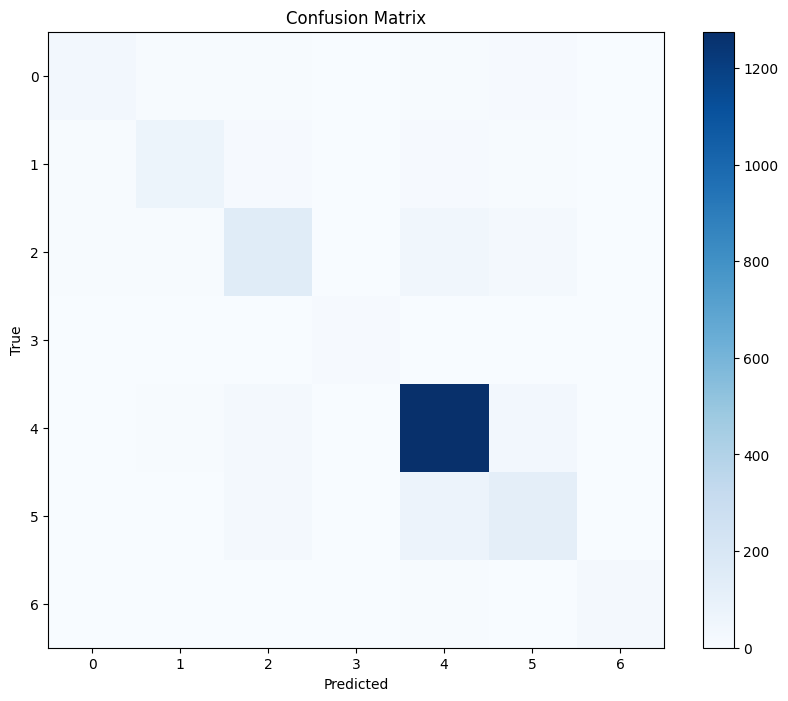

In [19]:
conf_matrix = confusion_matrix(np.argmax(val_labels, axis=1), val_preds)
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, cmap='Blues')
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


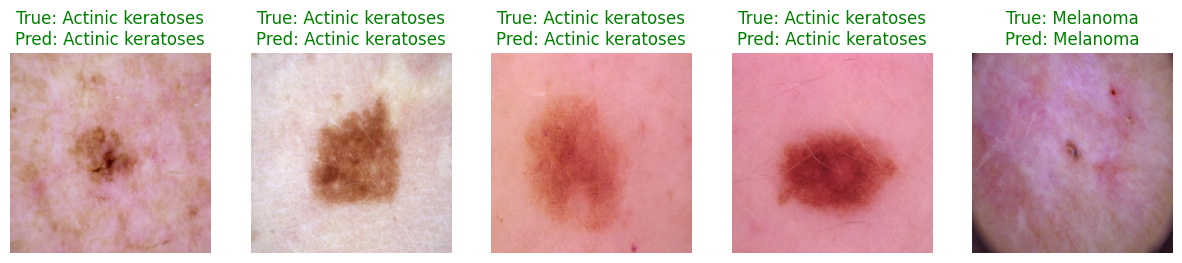

In [21]:
# Function to decode label index to class name
def decode_label(index):
    return list(lesion_label_dict.values())[index]

# Show predictions on some validation images
def display_predictions(model, dataset, num_samples=5):
    for images, labels in dataset.take(1):
        preds = model.predict(images)
        predicted_labels = np.argmax(preds, axis=1)
        true_labels = np.argmax(labels, axis=1)

        plt.figure(figsize=(15, 15))
        for i in range(num_samples):
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(images[i].numpy())
            plt.axis('off')
            plt.title(
                f"True: {decode_label(true_labels[i])}\nPred: {decode_label(predicted_labels[i])}",
                color="green" if true_labels[i] == predicted_labels[i] else "red",
            )
        plt.show()

# Display Predictions
display_predictions(model, val_dataset)
